In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv('/kaggle/input/masculinity-saturday-twitter-sentiment-analysis/twitter_sentiment_analysis_masculinity_saturday_data_annotated.csv', index_col=0)

In [4]:
df.head()

,tweet_created_at,text,Positive,Negative,Neutral,Compound,Sentiment
0,2022-12-30 22:37:46+00:00,Men who have refused to listen to/attend @amer...,0.000,0.073,0.927,-0.2960,Negative
1,2022-12-30 22:30:58+00:00,@OvOBrezzzy Take amerix next,0.000,0.000,1.000,0.0000,Neutral
2,2022-12-30 22:18:00+00:00,@AyodeleYo11 @amerix Nah I’m good my masculini...,0.493,0.068,0.439,0.8271,Positive
3,2022-12-30 20:42:54+00:00,@Amerix_DontSimp There is no need for dating i...,0.000,0.180,0.820,-0.2960,Negative
4,2022-12-30 20:32:23+00:00,@DyeAnna7 @amerix @kibe From what cos nothing ...,0.110,0.000,0.890,0.6908,Positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248738 entries, 0 to 248738
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tweet_created_at  248738 non-null  object 
 1   text              248738 non-null  object 
 2   Positive          248738 non-null  float64
 3   Negative          248738 non-null  float64
 4   Neutral           248738 non-null  float64
 5   Compound          248738 non-null  float64
 6   Sentiment         248738 non-null  object 
dtypes: float64(4), object(3)
memory usage: 15.2+ MB


In [6]:
df['tweet_created_at'] = pd.to_datetime(df['tweet_created_at'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248738 entries, 0 to 248738
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   tweet_created_at  248738 non-null  datetime64[ns, UTC]
 1   text              248738 non-null  object             
 2   Positive          248738 non-null  float64            
 3   Negative          248738 non-null  float64            
 4   Neutral           248738 non-null  float64            
 5   Compound          248738 non-null  float64            
 6   Sentiment         248738 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), object(2)
memory usage: 15.2+ MB


In [8]:
df.shape

(248738, 7)

In [9]:
df.drop_duplicates(subset='text',inplace=True)

In [10]:
df.shape

(236023, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236023 entries, 0 to 248738
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   tweet_created_at  236023 non-null  datetime64[ns, UTC]
 1   text              236023 non-null  object             
 2   Positive          236023 non-null  float64            
 3   Negative          236023 non-null  float64            
 4   Neutral           236023 non-null  float64            
 5   Compound          236023 non-null  float64            
 6   Sentiment         236023 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), object(2)
memory usage: 14.4+ MB


In [12]:
tweets_per_day = df['tweet_created_at'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

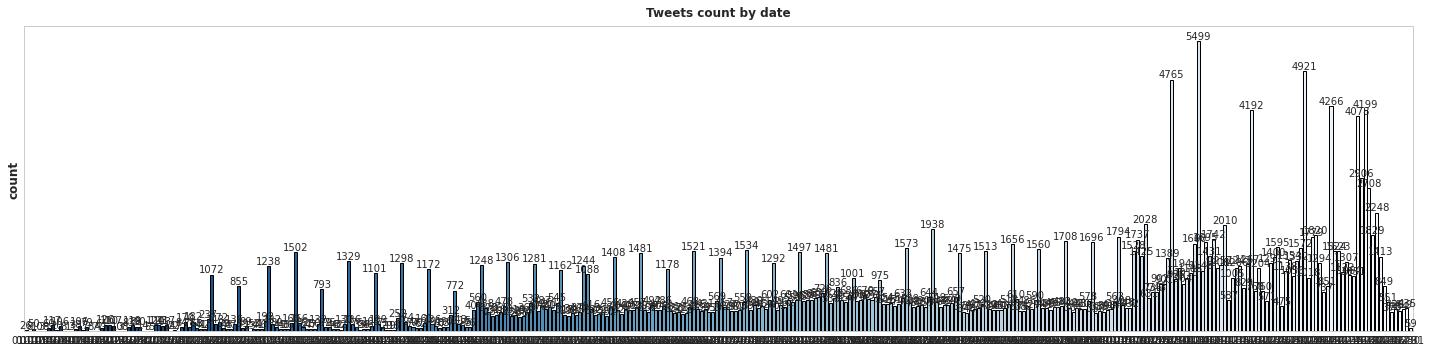

In [13]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day, edgecolor = 'black', ci=False, palette='Blues_r')

plt.title('Tweets count by date')
plt.yticks([])

ax.bar_label(ax.containers[0])

plt.ylabel('count')
plt.xlabel('')
plt.show()

In [14]:
df_1 = df[['text','Sentiment']]

In [15]:
df_1.head()

,text,Sentiment
0,Men who have refused to listen to/attend @amer...,Negative
1,@OvOBrezzzy Take amerix next,Neutral
2,@AyodeleYo11 @amerix Nah I’m good my masculini...,Positive
3,@Amerix_DontSimp There is no need for dating i...,Negative
4,@DyeAnna7 @amerix @kibe From what cos nothing ...,Positive


In [16]:
# remove multiple spaces

def remove_mult_spaces(text): 
    return re.sub("\s\s+" , " ", text)

In [17]:
#remove emoji

def strip_emoji(text):
    return re.sub(emoji.emoji_list(text), r"", text) 

In [18]:
#Remove punctuations, links, mentions and \r\n new line characters

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [19]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2


In [20]:
#Filter special characters such as & and $ present in some words

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)


In [21]:
texts_new = []
for t in df.text:
    texts_new.append(
        remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities((t)))))
    )

In [22]:
df['text_clean'] = texts_new

In [23]:
df['text'].head(10)

0    Men who have refused to listen to/attend @amer...
1                         @OvOBrezzzy Take amerix next
2    @AyodeleYo11 @amerix Nah I’m good my masculini...
3    @Amerix_DontSimp There is no need for dating i...
4    @DyeAnna7 @amerix @kibe From what cos nothing ...
5    @salim_the_don @MwendiaJnr I see you unblocked...
6    @german_kenyan @ML_Philosophy 🤣 yes they are a...
7    @PadreMusa Amerix once said the alcohol menace...
8    @DodoPicard You're in Eastafrica, he probably ...
9                     @HBK_ACTIVIST @amerix @kibe Heal
Name: text, dtype: object

In [24]:
df['text_clean'].head(10)

0    men who have refused to listen toattend classe...
1                                     take amerix next
2    nah im good my masculinity health and wellness...
3       there is no need for dating in the first place
4    from what cos nothing is changing and if we go...
5    i see you unblocked me one minute uko kwa amer...
6    yes they are also those who can cook i would r...
7    amerix once said the alcohol menace is wreckin...
8         youre in eastafrica he probably knows amerix
9                                                 heal
Name: text_clean, dtype: object

In [25]:
df['text_clean'][1:8].values

array(['take amerix next',
       'nah im good my masculinity health and wellness are fine thank you',
       'there is no need for dating in the first place',
       'from what cos nothing is changing and if we got people who have heal and thy are healing the nation then its good cos men have got platform to empower each other and even you ladies have got platform to learn what men are sharing',
       'i see you unblocked me one minute uko kwa amerixkibe mnasema marriage is a prison for menthe next your here blaming feminism for not getting wives one would assume given the first statement that men wouldnt want to marry kumbe it is the exact opposite mnashangaza',
       'yes they are also those who can cook i would recognize one too bad he aint on twitterbut i dont know if i want to date i view amerixs page cant help but think how misled most men are and cant be suitable for me at all',
       'amerix once said the alcohol menace is wrecking among the youths of kenya and especially t

In [26]:
text_len = []

for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [27]:
df['text_len'] = text_len

In [28]:
df.head()

,tweet_created_at,text,Positive,Negative,Neutral,Compound,Sentiment,text_clean,text_len
0,2022-12-30 22:37:46+00:00,Men who have refused to listen to/attend @amer...,0.000,0.073,0.927,-0.2960,Negative,men who have refused to listen toattend classe...,27
1,2022-12-30 22:30:58+00:00,@OvOBrezzzy Take amerix next,0.000,0.000,1.000,0.0000,Neutral,take amerix next,3
2,2022-12-30 22:18:00+00:00,@AyodeleYo11 @amerix Nah I’m good my masculini...,0.493,0.068,0.439,0.8271,Positive,nah im good my masculinity health and wellness...,12
3,2022-12-30 20:42:54+00:00,@Amerix_DontSimp There is no need for dating i...,0.000,0.180,0.820,-0.2960,Negative,there is no need for dating in the first place,10
4,2022-12-30 20:32:23+00:00,@DyeAnna7 @amerix @kibe From what cos nothing ...,0.110,0.000,0.890,0.6908,Positive,from what cos nothing is changing and if we go...,45


In [29]:
df.columns

Index(['tweet_created_at', 'text', 'Positive', 'Negative', 'Neutral',
       'Compound', 'Sentiment', 'text_clean', 'text_len'],
      dtype='object')

In [30]:
df = df[['tweet_created_at', 'text', 'text_clean', 'Sentiment', 'text_len']]

In [31]:
df.head()

,tweet_created_at,text,text_clean,Sentiment,text_len
0,2022-12-30 22:37:46+00:00,Men who have refused to listen to/attend @amer...,men who have refused to listen toattend classe...,Negative,27
1,2022-12-30 22:30:58+00:00,@OvOBrezzzy Take amerix next,take amerix next,Neutral,3
2,2022-12-30 22:18:00+00:00,@AyodeleYo11 @amerix Nah I’m good my masculini...,nah im good my masculinity health and wellness...,Positive,12
3,2022-12-30 20:42:54+00:00,@Amerix_DontSimp There is no need for dating i...,there is no need for dating in the first place,Negative,10
4,2022-12-30 20:32:23+00:00,@DyeAnna7 @amerix @kibe From what cos nothing ...,from what cos nothing is changing and if we go...,Positive,45


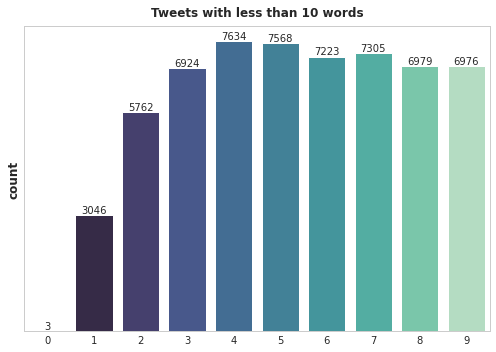

In [32]:
plt.figure(figsize=(7,5))

ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')

plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])

plt.ylabel('count')
plt.xlabel('')
plt.show()

In [33]:
df.shape

(236023, 5)

In [34]:
df = df[df['text_len'] > 1]

In [35]:
df.shape

(232974, 5)

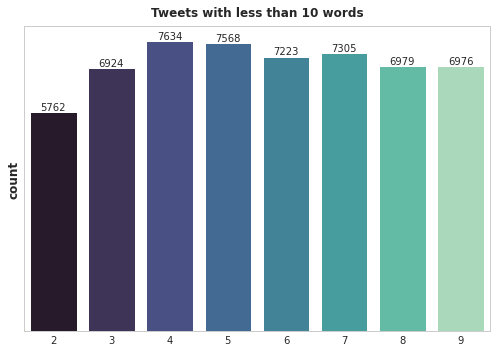

In [36]:
plt.figure(figsize=(7,5))

ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')

plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])

plt.ylabel('count')
plt.xlabel('')
plt.show()

In [37]:
df.head()

,tweet_created_at,text,text_clean,Sentiment,text_len
0,2022-12-30 22:37:46+00:00,Men who have refused to listen to/attend @amer...,men who have refused to listen toattend classe...,Negative,27
1,2022-12-30 22:30:58+00:00,@OvOBrezzzy Take amerix next,take amerix next,Neutral,3
2,2022-12-30 22:18:00+00:00,@AyodeleYo11 @amerix Nah I’m good my masculini...,nah im good my masculinity health and wellness...,Positive,12
3,2022-12-30 20:42:54+00:00,@Amerix_DontSimp There is no need for dating i...,there is no need for dating in the first place,Negative,10
4,2022-12-30 20:32:23+00:00,@DyeAnna7 @amerix @kibe From what cos nothing ...,from what cos nothing is changing and if we go...,Positive,45


In [38]:
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

2023-01-25 10:17:01.678815: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [39]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [41]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 90


In [42]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 338, TEXT: yesanakuambia leo marriage is a scam kesho unaskia a man must have a family siku ingine amerix ameamka akasema never trust a man who doesnt have a babymama then again akarudi kusema ati its weak men who made these babymamas tweeps wanawezafanya uishi maisha mbaya
INDEX: 19419, TEXT: kitu amerix amesaidia nayo watu sana ni kutufungulia macho we no longer simp bana i used to simp alot saa hizi bora nimesense hauwezikani hata kabla niambiwe naendanga dont waste your resources on someone who have no intention of commiting to you in any way
INDEX: 33174, TEXT: househelps holiday releavers dayburg and cleaners available call0716253784 0721147366 0115836665 0788446796 0789419588 0757823747 waterfront karen peter drury president ruto humphrey kariuki azimio masculinitysaturday kisumu mzee baba congratulations sir ayew amerix
INDEX: 47558, TEXT: get this hp revolve 810 g3 at 29999 this month callwhatsapp 0716 000565 get free hp headsets ichwareri citizen tv weston hotel julian

In [43]:
df['token_lens'] = token_lens

In [44]:
df.head(5)

,tweet_created_at,text,text_clean,Sentiment,text_len,token_lens
0,2022-12-30 22:37:46+00:00,Men who have refused to listen to/attend @amer...,men who have refused to listen toattend classe...,Negative,27,37
1,2022-12-30 22:30:58+00:00,@OvOBrezzzy Take amerix next,take amerix next,Neutral,3,7
2,2022-12-30 22:18:00+00:00,@AyodeleYo11 @amerix Nah I’m good my masculini...,nah im good my masculinity health and wellness...,Positive,12,17
3,2022-12-30 20:42:54+00:00,@Amerix_DontSimp There is no need for dating i...,there is no need for dating in the first place,Negative,10,12
4,2022-12-30 20:32:23+00:00,@DyeAnna7 @amerix @kibe From what cos nothing ...,from what cos nothing is changing and if we go...,Positive,45,50


In [45]:
df = df.sort_values(by='token_lens', ascending=False)

In [46]:
df.head(20)

,tweet_created_at,text,text_clean,Sentiment,text_len,token_lens
196994,2022-07-30 18:09:00+00:00,Well vetted house help available and ready to ...,well vetted house help available and ready to ...,Positive,35,90
201439,2022-07-09 09:30:05+00:00,HP EliteBook Revolve 810 G3\nIntel Core i5\n8G...,hp elitebook revolve 810 g3 intel core i5 8gb ...,Neutral,40,90
197618,2022-07-30 07:07:11+00:00,Well vetted house help available and ready to ...,well vetted house help available and ready to ...,Positive,35,90
35869,2022-12-03 08:04:17+00:00,"Househelps, Holiday releavers, Dayburg and cle...",househelps holiday releavers dayburg and clean...,Positive,30,89
175039,2022-11-12 06:10:39+00:00,"Ruracio for a Kamba chick:\n\n84 goats, 12 cow...",ruracio for a kamba chick 84 goats 12 cows 3 w...,Positive,47,89
217892,2022-04-16 19:13:12+00:00,1.Riftvalley Vs LuoNyanza\nNandi Gvr -32yrs\nN...,1riftvalley vs luonyanza nandi gvr 32yrs nandi...,Positive,47,89
194590,2022-08-20 09:58:15+00:00,TCL 43inch P735 Smart 4k HDR Google TV ksh.39...,tcl 43inch p735 smart 4k hdr google tv ksh3950...,Positive,36,88
179129,2022-10-23 05:11:18+00:00,AMOLLO JAILED FOR 8yrs.\nAMOLLO FACED Nyayo Ho...,amollo jailed for 8yrs amollo faced nyayo hous...,Negative,46,88
199654,2022-07-16 21:19:00+00:00,We have well vetted house helps countrywide re...,we have well vetted house helps countrywide re...,Positive,32,88
194579,2022-08-20 10:05:09+00:00,Truck #safari #beachcamping and #party of the ...,truck safari beachcamping and party of the yea...,Positive,35,88


In [47]:
df = df.iloc[12:]

In [48]:
df.head()

,tweet_created_at,text,text_clean,Sentiment,text_len,token_lens
246091,2020-08-14 10:44:11+00:00,"Chukua the ATAB 4G Tablet PC for your kids,for...",chukua the atab 4g tablet pc for your kidsfor ...,Negative,37,87
194565,2022-08-20 10:24:48+00:00,"Sony S700RF, 1000W 2 tall boys Soundbar ksh.54...",sony s700rf 1000w 2 tall boys soundbar ksh5450...,Neutral,36,87
208299,2022-06-04 18:07:52+00:00,Mounting and Framing photos Call:0208052887/07...,mounting and framing photos call02080528870727...,Neutral,39,87
168675,2022-12-10 12:47:20+00:00,BRAND NEW HP 240 LAPTOPS\nCORE i3\n1TB HARD DI...,brand new hp 240 laptops core i3 1tb hard disk...,Positive,43,86
192330,2022-08-28 03:46:19+00:00,Filmora 11 Crack➡️https://t.co/C4kYRyxh3k\n\n#...,filmora 11 crack masculinitysaturday maduriyet...,Neutral,20,86


In [49]:
df = df.sample(frac=1).reset_index(drop=True)

In [50]:
df.head(5)

,tweet_created_at,text,text_clean,Sentiment,text_len,token_lens
0,2022-12-05 09:07:25+00:00,@amerix Candidiasis is tearing women apart. Wo...,candidiasis is tearing women apart women are n...,Negative,39,48
1,2021-11-12 11:42:18+00:00,There's a buffet and you came with your home t...,theres a buffet and you came with your home tr...,Positive,30,40
2,2022-07-04 19:31:34+00:00,❤️Let's drop some @amazon lists\n💥 RT #wantlis...,lets drop some lists rt wantlists sprinkle if ...,Negative,15,34
3,2022-11-05 16:38:44+00:00,@amerix This is no joke,this is no joke,Neutral,4,6
4,2022-11-29 14:35:13+00:00,Our stories and characters help your students ...,our stories and characters help your students ...,Positive,30,50


In [51]:
df['Sentiment'].value_counts()

Positive    129038
Neutral      62536
Negative     41388
Name: Sentiment, dtype: int64

In [52]:
df['Sentiment'] = df['Sentiment'].map({'Negative':0,'Positive':1,'Neutral':2})

In [53]:
df['Sentiment'].value_counts()

1    129038
2     62536
0     41388
Name: Sentiment, dtype: int64

In [54]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));

train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [55]:
train_os['Sentiment'].value_counts()

0    129038
1    129038
2    129038
Name: Sentiment, dtype: int64